In [71]:
"""
Created on Mon Sep 18 22:28:01 2023

@author: merle
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pch
import plotly.express as px
import plotly.graph_objects as go
import nbformat
import os

#choose if sub dwarfs be included in plot:

<span style="color:#c44d6d">


#### To do when using this notebook:

1. Put in names of targets as found in UltracoolSheet.csv
2. Choose to incl. or excl. subdwarfs and exoplanets in the plot ('Sd')


</span>

In [72]:
showSubdwarfs = True
showExoplanets = True

In [73]:
simp0136 = 'SIMP J013656.5+093347.3'
simp0136_label = 'J0136'

inspected = [simp0136]
inspectLabel = [simp0136_label]
inspectColor = ['forestgreen', 'deepskyblue','goldenrod','slateblue','tomato','darkred'] #assign each target with custom color

In [74]:

# File path and URL
file_path = 'UltracoolSheet.csv'
url = "https://zenodo.org/records/10573247/files/UltracoolSheet%20-%20Main.csv?download=1"

# Check if file exists locally
if os.path.exists(file_path):
    # Load the CSV from the local file
    ultracool = pd.read_csv(file_path)
    print(f"Loaded data from local file: {file_path}")
else:
    # Download and load the CSV from the URL
    ultracool = pd.read_csv(url)
    print(f"Downloaded data from URL: {url}")

print(ultracool.head())



Downloaded data from URL: https://zenodo.org/records/10573247/files/UltracoolSheet%20-%20Main.csv?download=1
                        name               name_simbadable  \
0   ULAS J000010.43+113602.2      ULAS J000010.43+113602.2   
1   SDSS J000013.54+255418.6       2MASS J00001354+2554180   
2      PSO J000.2794+16.6237  Gaia DR2 2772504778021649152   
3   SDSS J000112.18+153535.5       2MASS J00011217+1535355   
4  WISEA J000131.93-084126.9       2MASS J00013166-0841234   

                ref_discovery  ra_j2000_formula  dec_j2000_formula  \
0                      Card15            0.0432            11.6020   
1                      Knap04            0.0565            25.9050   
2  Alle16b;Reyl18-phot;Sang23            0.2792            16.6241   
3                      Knap04            0.3007            15.5932   
4                     Luhm14c            0.3820            -8.6900   

  source_j2000_formula  glon_j2000  glat_j2000 literature_flag  \
0              CatWISE    103.4

In [75]:

#exclude all rows where plx_formula AND dist are nan and all columns that are irrelevant
uc = pd.DataFrame(ultracool, columns=['name', 'exoplanet', 'J_MKO', 'K_MKO', 'H_MKO' , 'plx_formula', 'dist_formula', 'sptnum_formula'])
uc.dropna(subset=['J_MKO', 'K_MKO', 'sptnum_formula'], inplace=True)  # Keeps rows where these columns are not NaN
uc = uc[~(uc['dist_formula'].isna() & uc['plx_formula'].isna())]  # Deletes rows where both dist_formula and plx_formula are NaN
uc['plx_formula'] /= 1000 #convert parallax to mas as in uc

def absMagPlx(mag, plx):
    Mag = mag + 5*(1+np.log10(plx))
    return Mag


def absMagDist(mag, dist):
    Mag = mag - 5*(np.log10(dist)-1)
    return Mag

In [76]:

if showSubdwarfs == False:
    uc.drop(uc[uc['sptnum_formula'] < 0].index, inplace = True)

#color: J_MKO - K_MKO:
uc['color'] = uc['J_MKO'] - uc['K_MKO']

# Calculate absolute magnitude based on the condition of 'plx_formula' being NaN or not
uc['absMag'] = np.where(
    uc['plx_formula'].notna(),  # Condition: if 'plx_formula' is not NaN
    absMagPlx(uc['J_MKO'], uc['plx_formula']),  # TRUE: Use absMagPlx when plx_formula is available (uses Plx to calc absMag)
    absMagDist(uc['J_MKO'], uc['dist_formula'])  # FALSE: Use absMagDist when plx_formula is NaN (uses Dist to calc absMag))
)


#spectral type and prep colors for plot
spectype_numkey = [
    (uc['sptnum_formula'] < 0),
    (uc['sptnum_formula'] >= 0) & (uc['sptnum_formula'] < 10),
    (uc['sptnum_formula'] >= 10) & (uc['sptnum_formula'] < 20),
    (uc['sptnum_formula'] >= 20) & (uc['sptnum_formula'] < 30),
    (uc['sptnum_formula'] >= 30),
    ] #numerical key to spectral types

specTypes = ['Sd', 'M', 'L', 'T', 'Y']
specColor = ['grey', 'lightcoral', 'crimson', 'dodgerblue', 'mediumorchid']
specCoords = [(0,10.1), (1.2,7.0), (0.5,12.5), (-1,14), (-0.5,24)]

if showSubdwarfs == False:
    spectype_numkey, specTypes, specColor, specCoords = spectype_numkey[1:], specTypes[1:], specColor[1:], specCoords[1:]
    

uc['spectype'] = np.select(spectype_numkey, specTypes, default='unknown')
uc['speccolor'] = np.select(spectype_numkey, specColor, default='black')

#now implement vals of whether or not has exoplanet
uc.loc[uc['exoplanet'].str.contains('\?'), 'exoplanet'] = '1' #all possible exopl = 1 (incl ?)
uc.loc[uc['exoplanet'].str.contains('Y'), 'exoplanet'] = '2' #all definite exopl = 2
uc.loc[uc['exoplanet'].str.contains('N'), 'exoplanet'] = '0' #no exopl = 0
uc['exoplanet'] = uc['exoplanet'].astype(int)

#specType = lambda x: 'Y' if x<0 else 'M' if x>=0 and x<10 else 'L' if x>=10 and x<20 else 'T' if x>=20

Check that all included targets can be found in UltraCool.csv. If not, check spelling against that of the ultracool sheet.

In [77]:
# Check if all inspected target names are in uc['name']
missing_targets = [target for target in inspected if target not in uc['name'].values]

# If there are missing targets, print an error message for each
if missing_targets:
    for target in missing_targets:
        print(f"The target name you have chosen ({target}) can't be found in UltraCool.csv. "
              "\nPlease check the format and spelling of the target's name against the sheet which can be found at: "
              "\nhttps://docs.google.com/spreadsheets/d/1i98ft8g5mzPp2DNno0kcz4B9nzMxdpyz5UquAVhz-U8/edit?usp=sharing")
else:
    print("All inspected targets are found in the dataset.")

All inspected targets are found in the dataset.


### Static/fixed plot to exports to png if required

The following section produces a plot that, if required, can be exported as a *.png file. 

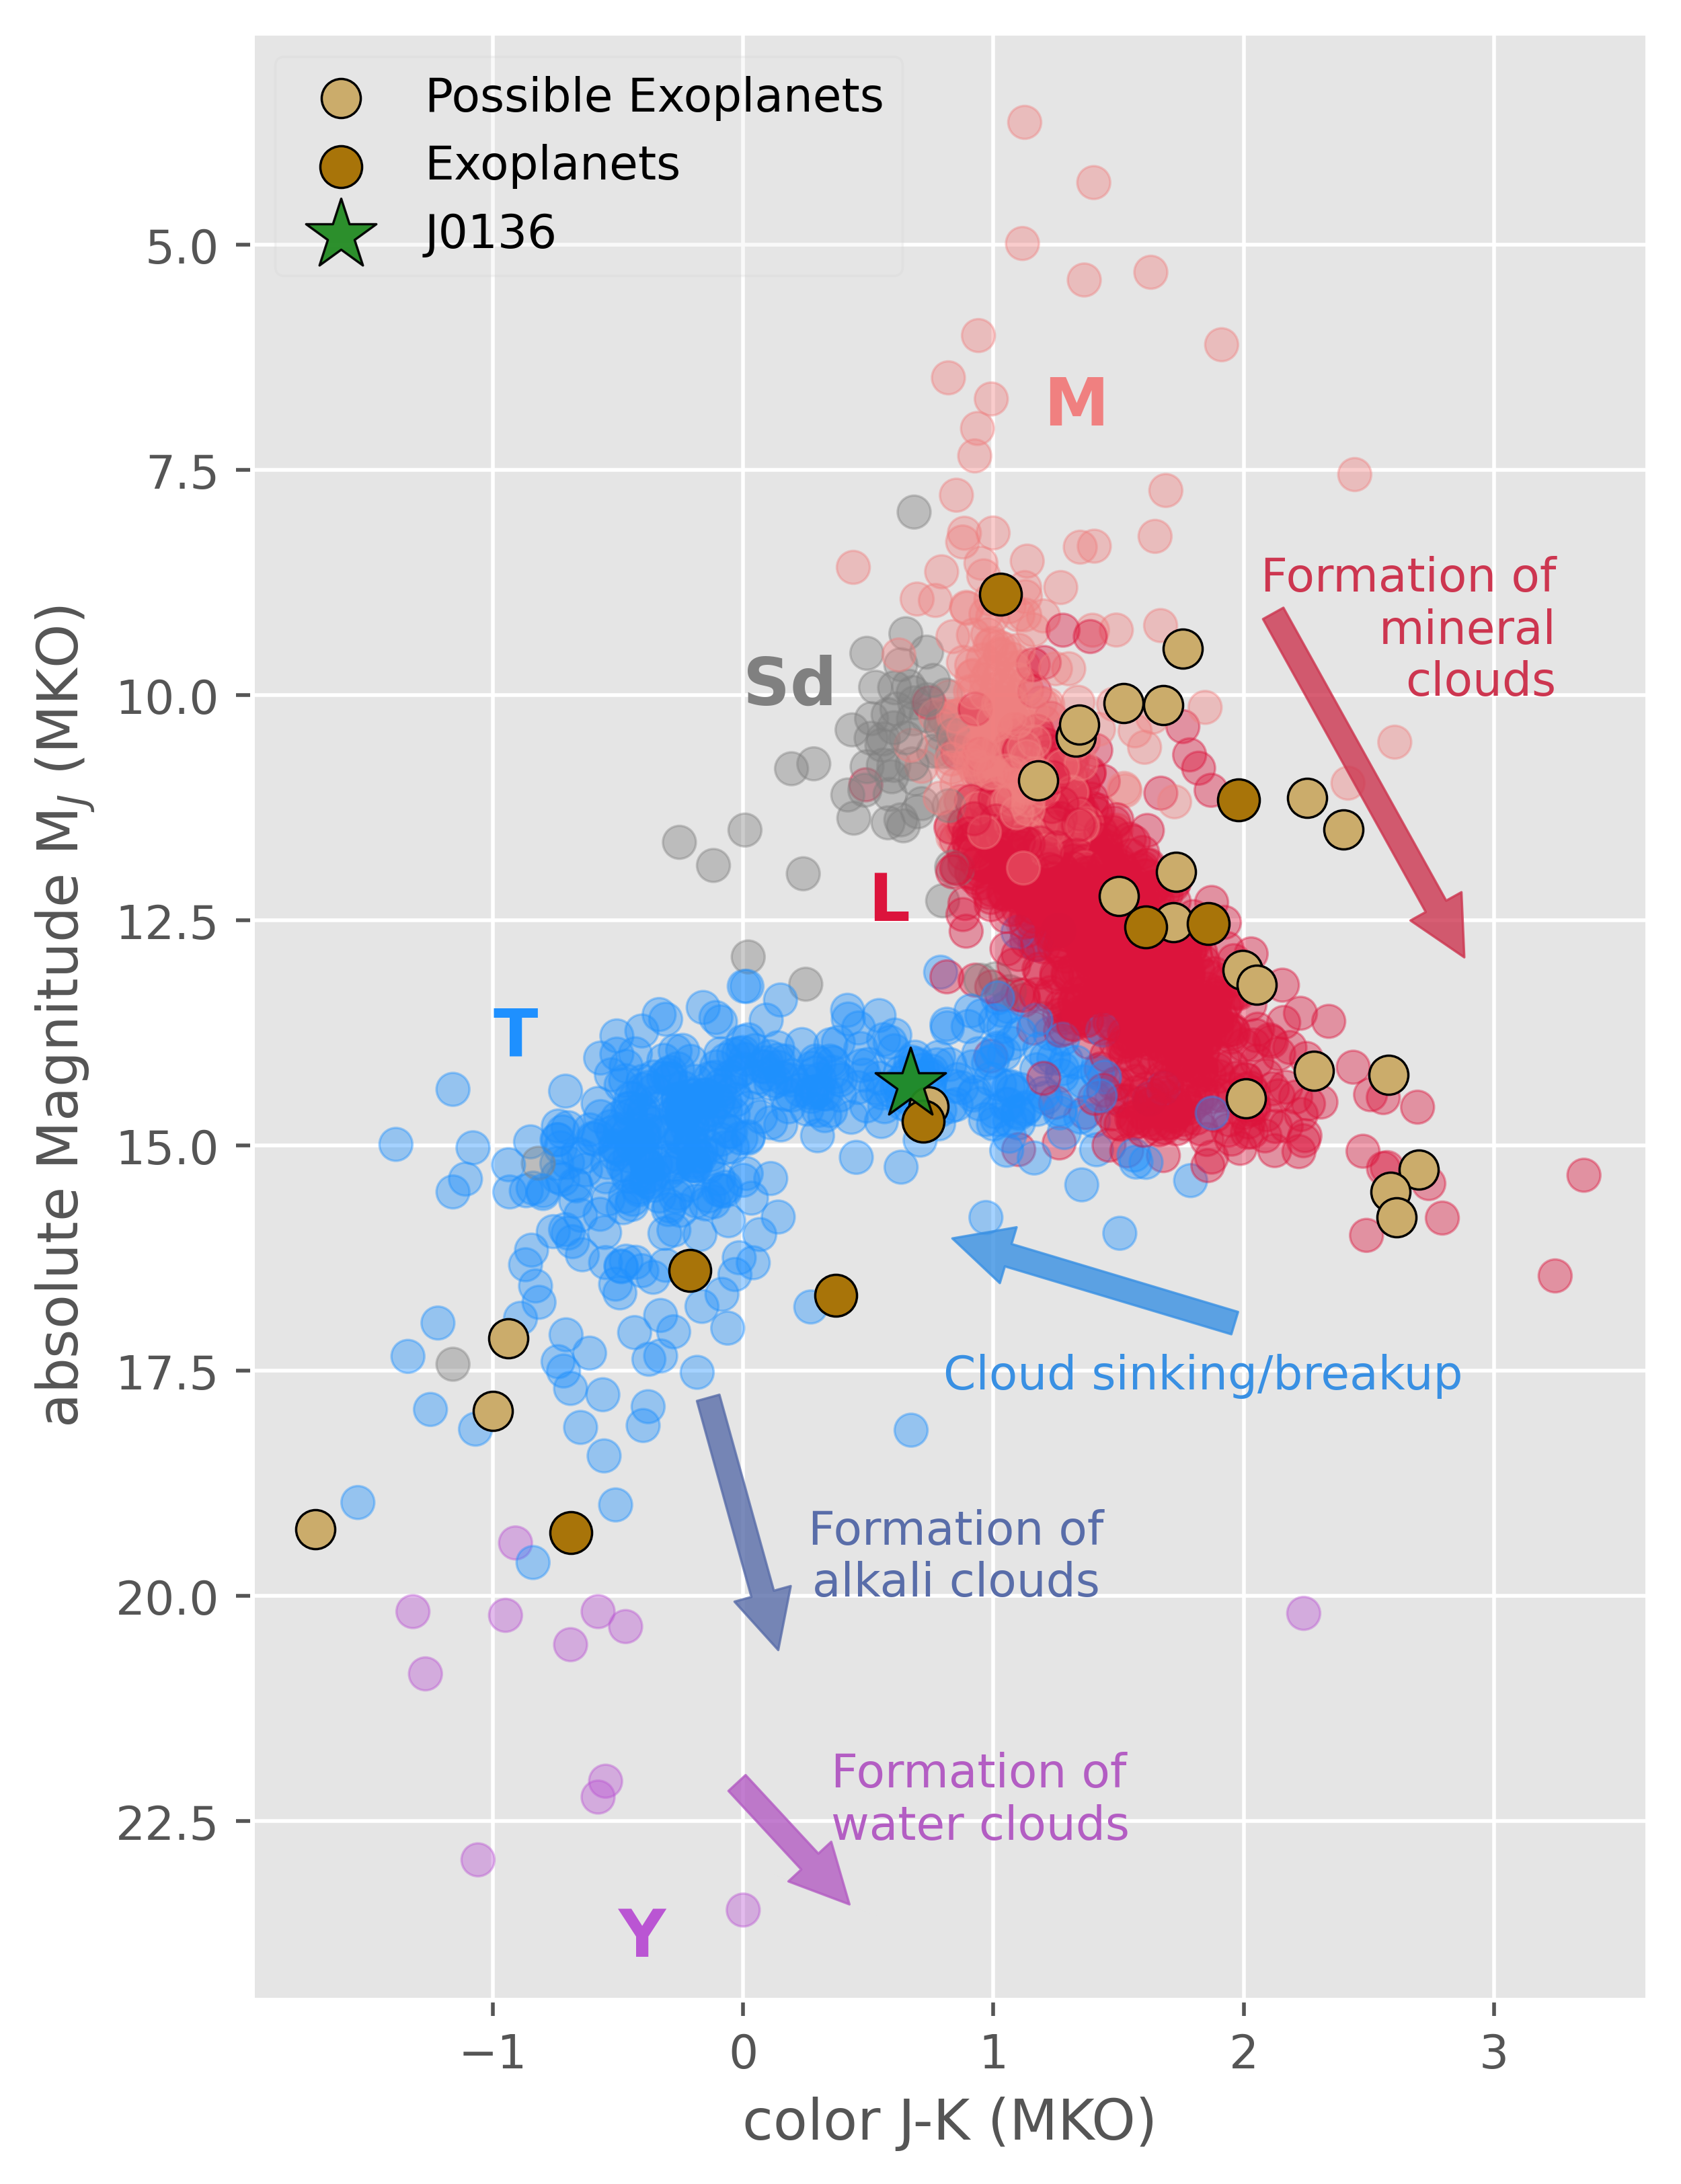

In [78]:

#scatter plot:
plt.figure(figsize=(5.1, 6.6), dpi=500)
 
plt.style.use('ggplot')
 
#plt.title('Color Magnitude (HRD) \nof Ultracool Field Dwarfs')
plt.xlabel('color J-K (MKO)')
plt.ylabel(r'absolute Magnitude M$_J$ (MKO)')

#plot brown dwarfs
plt.scatter(x=uc['color'][uc.exoplanet == 0],y=uc['absMag'][uc.exoplanet == 0],s=50,c=uc['speccolor'][uc.exoplanet == 0],alpha=0.4,marker='o')

if showExoplanets==True:
    #plot possible exoplanets
    plt.scatter(x=uc['color'][uc.exoplanet == 1],y=uc['absMag'][uc.exoplanet == 1],s=70,c='#cbac6b',alpha=1.0,marker='o',edgecolors='k', label="Possible Exoplanets")
    #plot exoplanets
    plt.scatter(x=uc['color'][uc.exoplanet == 2],y=uc['absMag'][uc.exoplanet == 2],s=80,c='#a87409',alpha=1.0,marker='o',edgecolors='k', label="Exoplanets")

#plot three objects to be inspected
for case,label,color in zip(inspected,inspectLabel,inspectColor):
    plt.scatter(x=uc['color'][uc.name == case], y=uc['absMag'][uc.name == case], s=250, c=color,alpha=0.95, edgecolors='k', label=label, marker='*')

#annotate spectral types
for (stype, coord, scolor) in zip(specTypes, specCoords, specColor):
    plt.annotate(stype, xy = coord, fontsize=14, color = scolor, fontweight = 'bold')

#arrows and cloud formation annotation:
arrowstart = [(2.1, 9),(2, 17),(-0.15, 17.7),(-0.05, 22)]
arrowstop = [(2.9,13),(0.8,16),(0.15,20.7),(0.45,23.5)]
arrowcolors = ['#cd3650','#3990e3','#596da9','#b35dc3']
for start,stop,color in zip(arrowstart,arrowstop,arrowcolors):
    arrow=pch.FancyArrowPatch(start, stop, mutation_scale=25, alpha=0.8, color=color)
    plt.gca().add_patch(arrow)
    
labelCoords = [(3.25,10), (0.8,17.7), (0.85,20), (0.35,22.7)]
labelWords = ['Formation of\nmineral\nclouds', 'Cloud sinking/breakup', 'Formation of\nalkali clouds', 'Formation of \nwater clouds']
labelAlign = ['right', 'left', 'center', 'left']
for (label, coord, color, align) in zip(labelWords, labelCoords, arrowcolors, labelAlign):
    plt.annotate(label, xy = coord, fontsize=10, color = color, ha=align)

plt.gca().invert_yaxis()
plt.legend(framealpha=0.2, loc='upper left') #loc='upper right'
plt.tight_layout()
plt.savefig(f"Images/ColorMagUC_{'-'.join(inspectLabel)}.png", bbox_inches='tight')
plt.show()



### Interactive Plot

The following piece of code produces an interactive plot that allows hovering over plotted points to see the targets name, colour and absolute magnitude. This can help when looking for targets that are of similar colour and magnitude as those plotted.

<span style="color:#c44d6d">

You can chose to annotate cloud development details, as annotated on the png plot above. This is not recommended, as it may get in the way of zooming/hovering over the plot. 

</span>

In [79]:
annotateCloudDevs=False

In [80]:
fig = go.Figure()

# Function to add scatter traces to Plotly figure
def add_scatter_trace(x, y, size, color, opacity, label, hover_text, edgecolor=None, marker_symbol=None):
    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        mode='markers',
        marker=dict(
            size=size,
            color=color,
            opacity=opacity,
            line=dict(width=1, color=edgecolor) if edgecolor else None,
            symbol=marker_symbol  

        ),
        name=label,
        text=hover_text,
        hoverinfo="text",
        showlegend=True,  # Enable legend for this trace
    ))

# Add brown dwarfs by spectral type
for spec_type, color in zip(specTypes, specColor):
    mask = (uc.exoplanet == 0) & (uc['spectype'] == spec_type) & (~uc['name'].isin(inspected))
    add_scatter_trace(
        uc['color'][(uc.exoplanet == 0) & (uc['spectype'] == spec_type)][mask],
        uc['absMag'][(uc.exoplanet == 0) & (uc['spectype'] == spec_type)][mask],
        size=12,
        color=color,
        opacity=0.4,
        label=f'{spec_type} Dwarfs',
        hover_text=[
            f"<b>{name}</b><br>Color: {color:.2f}<br>Abs Mag: {mag:.2f}"
            for name, color, mag in zip(
                uc['name'][(uc.exoplanet == 0) & (uc['spectype'] == spec_type)][mask],
                uc['color'][(uc.exoplanet == 0) & (uc['spectype'] == spec_type)][mask],
                uc['absMag'][(uc.exoplanet == 0) & (uc['spectype'] == spec_type)][mask]
            )
        ]
    )

if showExoplanets==True:
    # Add possible exoplanets
    add_scatter_trace(
        uc['color'][uc.exoplanet == 1],
        uc['absMag'][uc.exoplanet == 1],
        size=14,
        color='#cbac6b',
        opacity=1.0,
        label="Possible Exoplanets",
        hover_text=[
            f"<b>{name}</b><br>Color: {color:.2f}<br>Abs Mag: {mag:.2f}"
            for name, color, mag in zip(
                uc['name'][uc.exoplanet == 1],
                uc['color'][uc.exoplanet == 1],
                uc['absMag'][uc.exoplanet == 1]
            )
        ],
        edgecolor="black"
    )

    # Add exoplanets
    add_scatter_trace(
        uc['color'][uc.exoplanet == 2],
        uc['absMag'][uc.exoplanet == 2],
        size=16,
        color='#a87409',
        opacity=1.0,
        label="Exoplanets",
        hover_text=[
            f"<b>{name}</b><br>Color: {color:.2f}<br>Abs Mag: {mag:.2f}"
            for name, color, mag in zip(
                uc['name'][uc.exoplanet == 2],
                uc['color'][uc.exoplanet == 2],
                uc['absMag'][uc.exoplanet == 2]
            )
        ],
        edgecolor="black"
    )

# Add inspected objects
for case, label, color in zip(inspected, inspectLabel, inspectColor):
    add_scatter_trace(
        uc['color'][uc.name == case],
        uc['absMag'][uc.name == case],
        size=18,
        color=color,
        opacity=0.95,
        label=label,
        hover_text=[
            f"<b>{case}</b><br>Color: {uc['color'][uc.name == case].values[0]:.2f}<br>Abs Mag: {uc['absMag'][uc.name == case].values[0]:.2f}"
        ],
        edgecolor="black",
        marker_symbol='star'
    )


# Customize layout
fig.update_layout(
    title="Color Magnitude of Ultracool Dwarfs and Exoplanets",
    xaxis_title="Color J-K (MKO)",
    yaxis_title="Absolute Magnitude M<sub>J</sub> (MKO)",
    template='plotly_white',
    autosize=False,
    width=800,
    height=900,
    legend=dict(
        traceorder='normal',
        font=dict(
            size=12,),
    ),
)

# Invert y-axis to mimic HR diagram style
fig.update_yaxes(autorange="reversed")

if annotateCloudDevs==True:
    # Add arrows for annotations
    for start, stop, color in zip(arrowstart, arrowstop, arrowcolors):
        fig.add_annotation(
            x=stop[0],
            y=stop[1],
            ax=start[0],
            ay=start[1],
            xref="x",
            yref="y",
            axref="x",
            ayref="y",
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=1,
            arrowcolor=color,
        )

    # Add annotations for cloud formation
    for (label, coord, color, align) in zip(labelWords, labelCoords, arrowcolors, labelAlign):
        fig.add_annotation(
            x=coord[0],
            y=coord[1],
            text=label,
            showarrow=False,
            font=dict(color=color, size=11),
            align=align
        )
fig.show()